# Quora Question Pair Similarity

# Introduction

Quora is a platform for Q&A, just like StackOverflow. But quora is more of a general-purpose Q&A platform that means there is not much code like in StackOverflow.

One of the many problems that quora face is the duplication of questions. Duplication of question ruins the experience for both the questioner and the answerer. Since the questioner is asking a duplicate question, we can just show him/her the answers to the previous question. And the answerer doesn't have to repeat his/her answer for essentially the same questions.

For example, we have a question like "How can I be a good geologist?" and there are some answers to that question. Later someone else asks another question like "What should I do to be a great geologist?".<br>
We can see that both the questions are asking the same thing. Even though the wordings for the question are different, the intention of both questions is same. <br>
So the answers will be same for both questions. That means we can just show the answers of the first question. That way the person who is asking the question will get the answers immediately and people who have answered already the first question don't have to repeat themselves.

This problem is available on Kaggle as a competition. https://www.kaggle.com/c/quora-question-pairs


# Business Objectives and Constraints

- There is no strict latency requirement.
- We would like to have interpretability but it is not absolutely mandatory.
- The cost of misclassification is medium.
- Both classes (duplicate or not) are equally important.

# Importing Libraries and reading data

In [1]:

# Visualisation and dataframes
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Text cleaning and preprocessing
import re
import nltk
import unicodedata
import contractions
from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


# Vectorization and train-test-split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix


# Others
import warnings
from collections import Counter
from wordcloud import WordCloud,STOPWORDS

warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_colwidth',None)

In [2]:
df = pd.read_csv('train.csv')

In [3]:
print(df.shape)
df.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


# EDA

## 1. EDA on unprocessed data

In [4]:
print(df.columns, '\n')
print(df.is_duplicate.value_counts(), '\n')
print(df.shape)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object') 

0    255027
1    149263
Name: is_duplicate, dtype: int64 

(404290, 6)


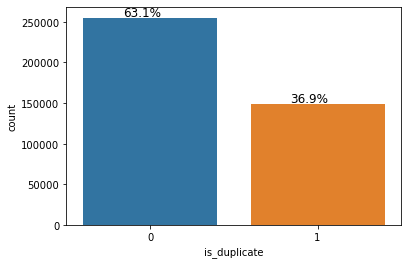

In [5]:
# plotting label distribution
def bar_plot(data, feature):
    plot = sns.countplot(x =feature, data = data)
    total = len(data)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y),ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points")
    plt.show()
    
bar_plot(df,'is_duplicate')

Available Columns : <b>id, qid1, qid2, question1, question2, is_duplicate</b><br>
Class labels : <b>0, 1</b><br>
Total training data / No. of rows :  <b>404290</b><br>
No. of columns :  <b>6</b><br>
**is_duplicate** is the dependent variable.<br>
No. of non-duplicate data points is <b>255027</b><br>
No. of duplicate data points is <b>149263</b>

We have **404290** training data points. And only **36.92%** are positive. That means it is an imbalanced dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

removing the null values since there are just 3

In [8]:
df = df.dropna()

In [9]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [10]:
# getting unique ids for each question
print('unique ids for question1 :', df.qid1.nunique())
print('unique ids for question1 :', df.qid2.nunique())

unique ids for question1 : 290652
unique ids for question1 : 299362


537929
808574


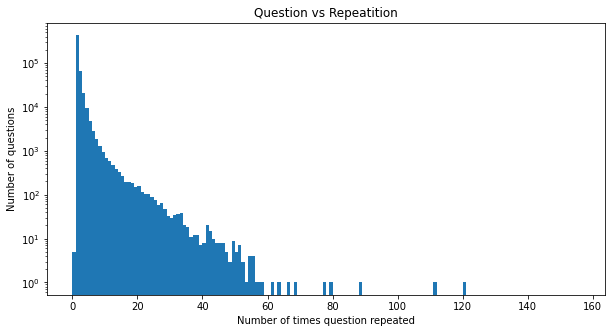

0 157


In [11]:
# checking questions vs Repetition
qids = np.append(df.qid1.values,df.qid2.values)
print(len(set(qids)))
print(len(qids))

occurences = np.bincount(qids)  # counts the occurence of every element in the array
plt.figure(figsize=(10,5)) 
plt.hist(occurences, bins=range(0,np.max(occurences)))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repeatition')
plt.show()
print(np.min(occurences), np.max(occurences))

* Out of **808574** total questions (including both question1 and question2), **537929** are unique.
* One question is repeated **157** times which is the max number of repetitions.

## 2. Data Cleaning
In this section we will clean the data inorder to get the important features from the data.
The following steps will be processed in a step by step fashion

In [12]:
def clean_text(text, lemma = True):
    # lowercase
    text = text.lower()
            
    # URL removal
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)
    
    # replace contractions
    text = contractions.fix(text)
    
    # replace accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    # remove special characters
    text = re.sub('[^a-zA-Z\s]', '', text)
    
    # emoji removal
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # split text to remove stopwords and lemmatize the text
    text = text.split()

    # remove stopwords
    stopwords_list = set(stopwords.words("english"))
    stopwords_list.remove('not')
    stopwords_list.remove('no')
    text = [word for word in text if word not in stopwords_list]
    
    # lemmatizing
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()

    if lemma:
#         text = lemmatizer.lemmatize(text)
        text = [lemmatizer.lemmatize(word) for word in text]
        text = [lemmatizer.lemmatize(word, "v") for word in text]
    else:
        text = [ps.stem(word) for word in text]
        
    return ' '.join(text)


#### Sampling the data
We need to sample the data in order to perform the rest of the analysis since the dataset contains around **400k** items which will require high computational power. Therefor, for the analysis purpose, we can use a small chunk of the dataset(around **80k**) samples.

In [13]:
X = df.drop('is_duplicate', axis = 1)
y = df['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.80, random_state = 0)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(80857, 5) (80857,)
(323430, 5) (323430,)


- We will use only 20% of the data for further cleaning since
- The test data is taken to be 80% fo the total data which can further be used for testing the model performance

In [15]:
# cleaning the train data
data = X_train.copy()
data['question1'] = data['question1'].apply(clean_text)
data['question2'] = data['question2'].apply(clean_text)

In [16]:
data.head()

,id,qid1,qid2,question1,question2
350474,350474,190838,107002,speak english native speaker,talk like native english speaker
61771,61771,2266,85864,get chance meet mr narendra modi,narendra modi meet modi
39801,39801,22110,26256,question mark improvement,question mark need improvement
2155,2155,4288,4289,data recovery lose contact iphone however icloud get back onto iphone,recover lose contact iphone
354900,354900,484080,484081,program language best suit,program language best suit script


Now since the data is clean and preprocessed, we can make new features for better analysis

## 3. Featurization
In this section we will create some features in order to get insights on how the question dimensions are related to the duplicacy

- **q1_char_count** - count of characters in question 1
- **q2_char_count** - count of characters in question 1
- **q1_word_count** - count of words in question 1
- **q2_word_count** - count of words in question 1
- **TOTAL_WORDS**   - total words in both questions combined
- **common_word_count** - number of common words in both questions
- **differ_word_count** - different words in both questions
- **first_word_same** - (1) if first word of both the questions is same else (0)
- **last_word_same** - (1) if last word of both the questions is same else (0)
- **unique_word_count** - number of unique words in both the questions

In [17]:
# function for checking if the first word/ last word is same
def is_same(data, index):
    q1, q2 = data['question1'], data['question2']
    q1 = q1.split()
    q2 = q2.split()
    if len(q1)>0 and len(q2)>0 and q1[index]==q2[index]:
        return 1
    else:
        return 0

In [18]:
# Extracting important features which might be useful for bussiness analysis
data['q1_char_count'] = data.question1.apply(len)
data['q2_char_count'] = data.question2.apply(len)
data['q1_word_count'] = data.question1.apply(lambda x: len(x.split()))
data['q2_word_count'] = data.question2.apply(lambda x: len(x.split()))
data['TOTAL_WORDS'] = data['q1_word_count'] + data['q2_word_count']
data['common_word_count'] = data.apply(lambda x: len(set(x.question1.split())&(set(x.question2.split()))) ,axis=1)
data['differ_word_count'] = abs(data['q1_word_count'] - data['q2_word_count'])
data['first_word_same'] = data.apply(lambda x: is_same(x, 0),axis=1)
data['last_word_same'] = data.apply(lambda x:  is_same(x, -1), axis = 1)
data['unique_word_count'] = data.apply(lambda x: len(set(x.question1.split())|(set(x.question2.split()))) ,axis=1)

In [19]:
data

,id,qid1,qid2,question1,question2,q1_char_count,q2_char_count,q1_word_count,q2_word_count,TOTAL_WORDS,common_word_count,differ_word_count,first_word_same,last_word_same,unique_word_count
350474,350474,190838,107002,speak english native speaker,talk like native english speaker,28,32,4,5,9,3,1,0,1,6
61771,61771,2266,85864,get chance meet mr narendra modi,narendra modi meet modi,32,23,6,4,10,3,2,0,1,6
39801,39801,22110,26256,question mark improvement,question mark need improvement,25,30,3,4,7,3,1,1,1,4
2155,2155,4288,4289,data recovery lose contact iphone however icloud get back onto iphone,recover lose contact iphone,69,27,11,4,15,3,7,0,1,11
354900,354900,484080,484081,program language best suit,program language best suit script,26,33,4,5,9,4,1,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359785,359785,489474,489475,java android,rjava android,12,13,2,2,4,1,0,0,1,3
358085,358085,487519,487520,proper length men pant,proper length men suit pant,22,27,4,5,9,4,1,1,1,5
152316,152316,239317,237326,know whether want mbbs something else,know really want become doctor,37,30,6,5,11,2,1,1,0,9
117953,117953,191822,191823,hack snapchat chat history,spy snapchat chat history,26,25,4,4,8,3,0,0,1,5


## 4. EDA on processed and cleaned data
- We will plot Probability Density Function(PDF) that will represent the likelihood of duplicacy
- Boxplot will be used for understanding outliers and quartiles

In [20]:
def plot_pdf_boxplot(feature):
    fig, ax =plt.subplots(1,2,figsize=(15,5))
    ax[0].title.set_text(f'PDF of {feature}')
    sns.kdeplot(data[feature], hue=y_train, palette="Dark2", ax=ax[0])
    ax[1].title.set_text(f'Boxplot of {feature}')
    sns.boxplot(x=y_train, y=data[feature], palette="Dark2", ax=ax[1])
    plt.show()

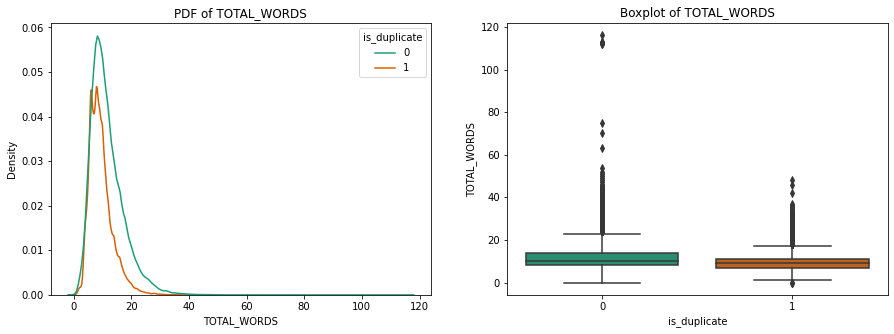

In [21]:
plot_pdf_boxplot('TOTAL_WORDS')

- no of duplicate questions is less for high number of total words of both the questions

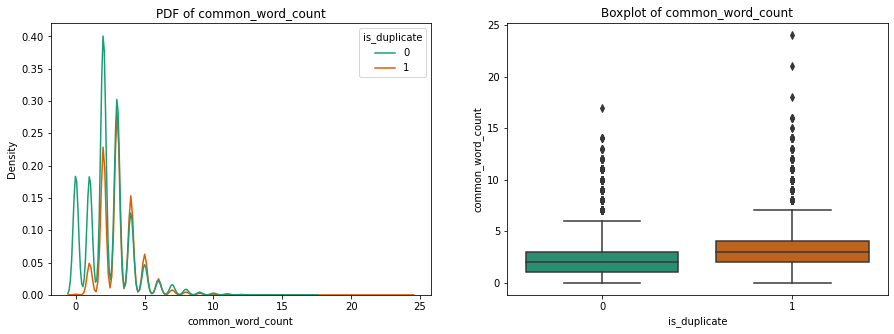

In [22]:
plot_pdf_boxplot('common_word_count')

- with less common words between q1 and q2, the probablity of duplicacy is less. 
- boxplot indeicates that most duplicate questions have around 3 to 5 common words whereas many have around 5 to 7
- there are many outliers in both duplicate and non duplicate questions

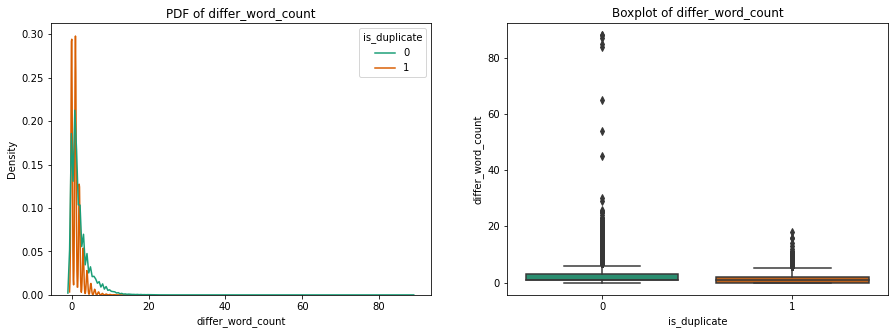

In [23]:
plot_pdf_boxplot('differ_word_count')

- question pairs with less different words have more duplicacy as seen from the PDF
- boxplot indicates the presence of outliers for non duplciate question pairs

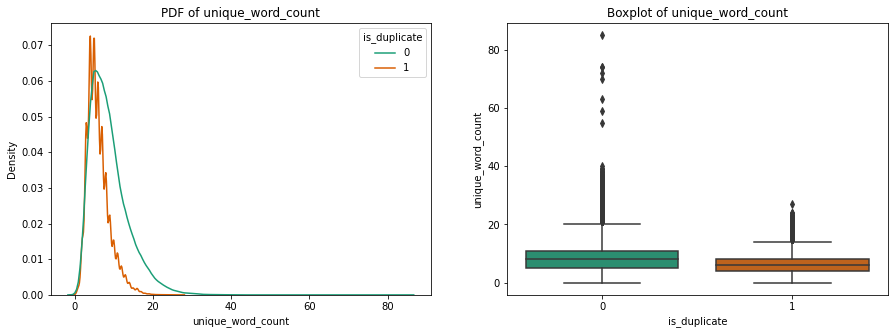

In [24]:
plot_pdf_boxplot('unique_word_count')

- question pairs with less unique words have more duplicacy as seen from PDF
- more the unique words, more are the probability of question pairs being non duplicate

In [25]:
def countplot(feature):
    sns.countplot(x=data[feature], hue=y_train, palette='Set1')
    plt.title(f'Countplot of {feature}')
    plt.legend(['not_duplicate', 'duplicate'])
    plt.show()

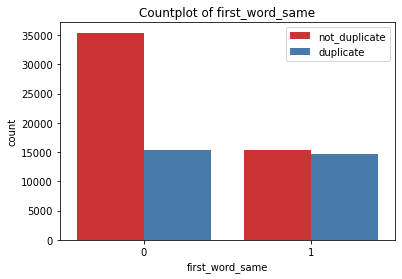

In [26]:
countplot('first_word_same')

- around 15000 question pairs have first word same
- around **14000** question pairs with same first words are duplicates

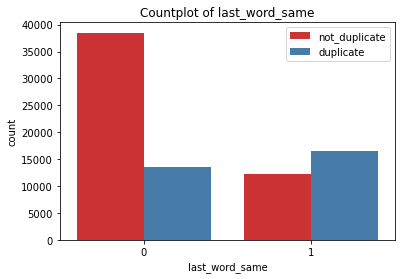

In [27]:
countplot('last_word_same')

- around 16000 question pairs have same last words
- around **16000** question pairs with same last words are duplicates

In [28]:
# describing text
print(data.question1.describe())
print()
print(data.question2.describe())

count                   80857
unique                  70008
top       new year resolution
freq                       70
Name: question1, dtype: object

count                   80857
unique                  70095
top       new year resolution
freq                       67
Name: question2, dtype: object


In [29]:
# finding the unique words and distribution of unique words
def unique_describe(feature):
    total_words = []
    for i in data[feature]:
        for j in i.split():
            total_words.append(j)
    unique, counts = np.unique(total_words, return_counts=True)
    print(f"Total number  words in {feature} are        : ", len(total_words))
    print(f"Total number of UNIQUE words in {feature} are : ", len(unique))
    
    ndf = pd.DataFrame({"Words" : unique, "Count":counts })
    ndf = ndf.sort_values(by ='Count', ascending=False)
    return ndf.describe()

In [30]:
print(unique_describe('question1'), '\n')
print(unique_describe('question2'))

Total number  words in question1 are        :  434486
Total number of UNIQUE words in question1 are :  27934
              Count
count  27934.000000
mean      15.554020
std       96.567017
min        1.000000
25%        1.000000
50%        1.000000
75%        5.000000
max     6712.000000 

Total number  words in question2 are        :  440681
Total number of UNIQUE words in question2 are :  25855
              Count
count  25855.000000
mean      17.044324
std      106.150095
min        1.000000
25%        1.000000
50%        2.000000
75%        5.000000
max     7245.000000


- The mean of the unique words in question1 and question2 are **15.53** and **16.98** with a standard deviation of **96.17** and **105.56**, respectively
- **75%** of the data(q1 and q2) has more than 5 unique words
- There are several outliers since the max unique word count is **6765** and **7233** for q1 and q2 respectively

# EDA conclusion

- Question paris with high number of word count are less likely to be duplicates
- More the common words in question pairs, more is the duplicacy, which is justified
- Most duplicate questions have around 3 to 5 common words whereas early outliers have around 5 to 7
- Question pairs with less unique words have more duplicacy
- around 14000 question pairs with same first words are duplicates
- around 16000 question pairs with same last words are duplicates
- The mean of the unique words in question1 and question2 are 15.53 and 16.98 with a std of 96.17 and 105.56, respectively
- 75% of the data(q1 and q2) has more than 5 unique words
- There are several outliers since the max unique word count is 6765 and 7233 for q1 and q2 respectively

# Future Work
- This notebook was focused on EDA on textural data with similarity detection
- Vectoriztion techniques like TF-IDF can be further used to create the term document matrix of the textural data
- Model training using XGBoost Classifer, Logistic Regression and Naive Bayes can further be performed on the training dataset.
- XGBoost Classifier when performed with hyperparameter tuning will give the best results
- The above mentioned steps have not been performed due to lack of computational power and extensiveness of the dataset